# tensorflow 2系列04 从0构建一个图像分类模型

本期文章是一个系列课程，本文是这个系列的第3篇复习笔记

(1)Build and train neural network models using TensorFlow 2.x  
(2)Image classification  
(3)Natural language processing(NLP)  
(4)Time series, sequences and predictions  

本次图像分类是从0构建一个生产可用的模型，主要包含以下步骤
* 数据处理
* 构建模型
* 检验模型效果
* 过拟合调优

## 数据处理
### 数据下载

In [3]:
import tensorflow as tf
import numpy as np
import os
import PIL
import matplotlib.pyplot as plt
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

In [4]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


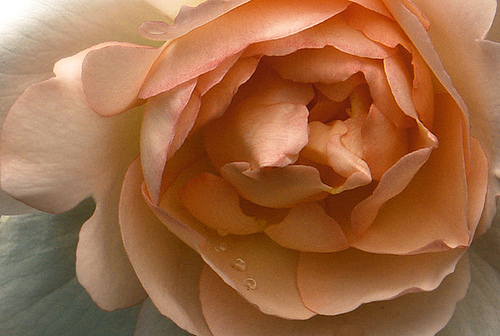

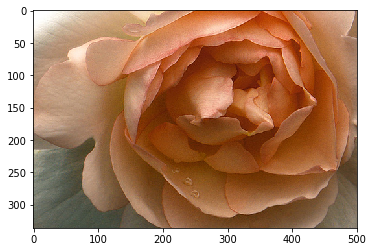

In [5]:
roses = list(data_dir.glob('roses/*'))
img=plt.imread(roses[0])
img.shape
plt.imshow(img)
PIL.Image.open(str(roses[0]))

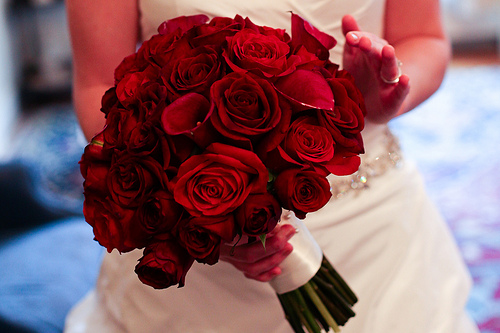

In [6]:

PIL.Image.open(str(roses[1]))

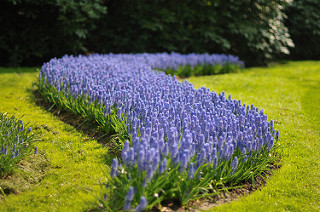

In [7]:
tulips = list(data_dir.glob('tulips/*'))
PIL.Image.open(str(tulips[0]))

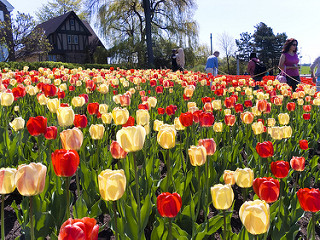

In [8]:
PIL.Image.open(str(tulips[1]))

### 创建数据集


In [9]:
batch_size = 32
img_height = 180
img_width = 180

# tf.keras.preprocessing.image.ImageDataGenerator
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
class_names = train_ds.class_names
print(class_names)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.
['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 可视化数据



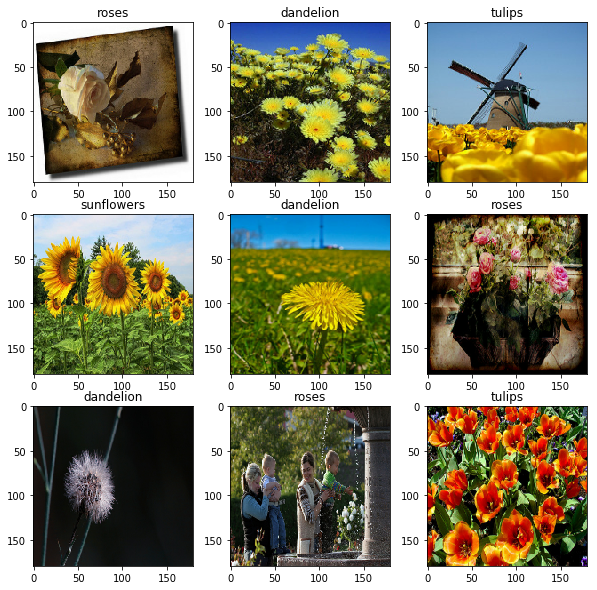

In [10]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])

In [11]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [12]:
AUTOTUNE =1000
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

In [13]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


## 定义模型

In [14]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation="softmax")
])

In [15]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_1 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

In [17]:
epochs=5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 75s 820ms/step - loss: 1.3372 - accuracy: 0.4251 - val_loss: 1.1366 - val_accuracy: 0.5327
Epoch 2/10
92/92 [==============================] - 78s 853ms/step - loss: 1.0179 - accuracy: 0.5967 - val_loss: 0.9823 - val_accuracy: 0.6144
Epoch 3/10
92/92 [==============================] - 76s 830ms/step - loss: 0.8487 - accuracy: 0.6751 - val_loss: 0.9487 - val_accuracy: 0.6349
Epoch 4/10
92/92 [==============================] - 78s 850ms/step - loss: 0.6887 - accuracy: 0.7347 - val_loss: 0.9510 - val_accuracy: 0.6308
Epoch 5/10
92/92 [==============================] - 78s 845ms/step - loss: 0.5139 - accuracy: 0.8164 - val_loss: 0.9651 - val_accuracy: 0.6485
Epoch 6/10
92/92 [==============================] - 86s 935ms/step - loss: 0.3263 - accuracy: 0.8852 - val_loss: 1.1030 - val_accuracy: 0.6458
Epoch 7/10
92/92 [==============================] - 75s 816ms/step - loss: 0.2124 - accuracy: 0.9288 - val_loss: 1.3012 - val_accuracy: 0.6322

### Visualize training results

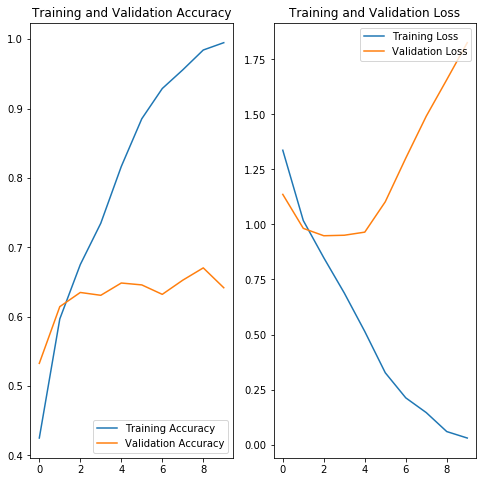

In [18]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 过拟合调优
#### 数据增强


In [19]:
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.experimental.preprocessing.RandomFlip("horizontal", 
                                                 input_shape=(img_height, 
                                                              img_width,
                                                              3)),
    tf.keras.layers.experimental.preprocessing.RandomRotation(0.1),
    tf.keras.layers.experimental.preprocessing.RandomZoom(0.1),
  ]
)

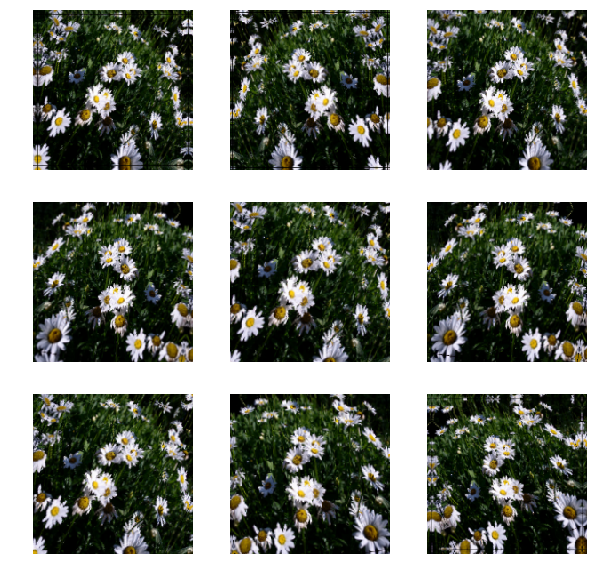

In [20]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

#### dropout

In [22]:
model = tf.keras.Sequential([
  data_augmentation,
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes,activation="softmax")
])
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_3 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 45, 45, 64)       

In [40]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
92/92 [==============================] - 95s 1s/step - loss: 0.6721 - accuracy: 0.7408 - val_loss: 0.7045 - val_accuracy: 0.7166
Epoch 2/10
92/92 [==============================] - 99s 1s/step - loss: 0.6427 - accuracy: 0.7493 - val_loss: 0.7460 - val_accuracy: 0.7166
Epoch 3/10
92/92 [==============================] - 100s 1s/step - loss: 0.6144 - accuracy: 0.7681 - val_loss: 0.7289 - val_accuracy: 0.7098
Epoch 4/10
92/92 [==============================] - 110s 1s/step - loss: 0.5959 - accuracy: 0.7830 - val_loss: 0.7078 - val_accuracy: 0.7357
Epoch 5/10
92/92 [==============================] - 92s 1s/step - loss: 0.5773 - accuracy: 0.7807 - val_loss: 0.7223 - val_accuracy: 0.7221
Epoch 6/10
92/92 [==============================] - 83s 905ms/step - loss: 0.5497 - accuracy: 0.7950 - val_loss: 0.7228 - val_accuracy: 0.7411
Epoch 7/10
92/92 [==============================] - 104s 1s/step - loss: 0.5245 - accuracy: 0.7984 - val_loss: 0.7433 - val_accuracy: 0.7275
Epoch 8/10
92/

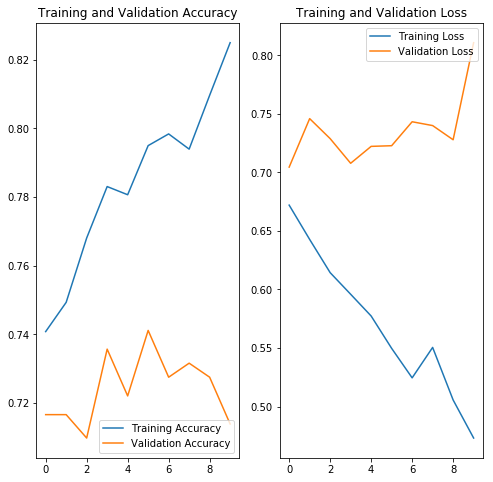

In [41]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [1]:
sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)

img = tf.keras.preprocessing.image.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
plt.imshow(img)
img_array = tf.keras.preprocessing.image.img_to_array(img)
print(img_array.shape)
img_array = tf.expand_dims(img_array, 0) # Create a batch
print(img_array.shape)

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(np.max(score))

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

NameError: name 'tf' is not defined